##### Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Style Transfer

Using Lucent for style transfer! For the Lucid version, see [here](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/style_transfer_2d.ipynb).

## Install, Import, Load Model

In [2]:
# !pip install --quiet git+https://github.com/greentfrapp/lucent.git

# !wget -qnc https://raw.githubusercontent.com/greentfrapp/lucent-notebooks/master/images/transfer_big_ben.png
# !wget -qnc https://raw.githubusercontent.com/greentfrapp/lucent-notebooks/master/images/transfer_vangogh.png
# !wget -qnc https://raw.githubusercontent.com/greentfrapp/lucent-notebooks/master/images/transfer_picasso.png

In [3]:
import torch
from PIL import Image
import numpy as np

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1
from lucent.misc.io import show
from lucent.optvis.objectives import wrap_objective

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True)
_ = model.to(device).eval()

## Load Images

In [5]:
def load(path):
    return np.array(Image.open(path)) / 255

(512, 512, 3) (512, 645, 3)



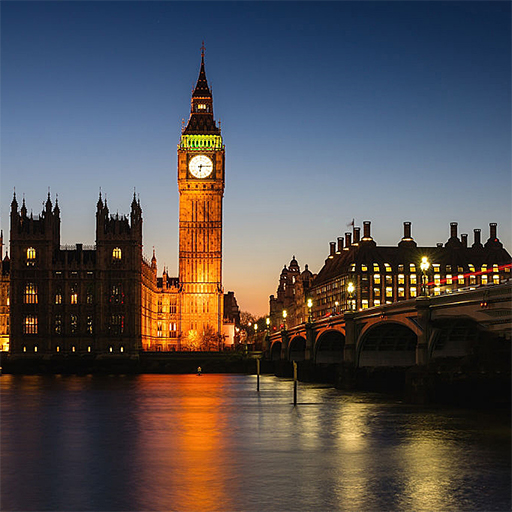


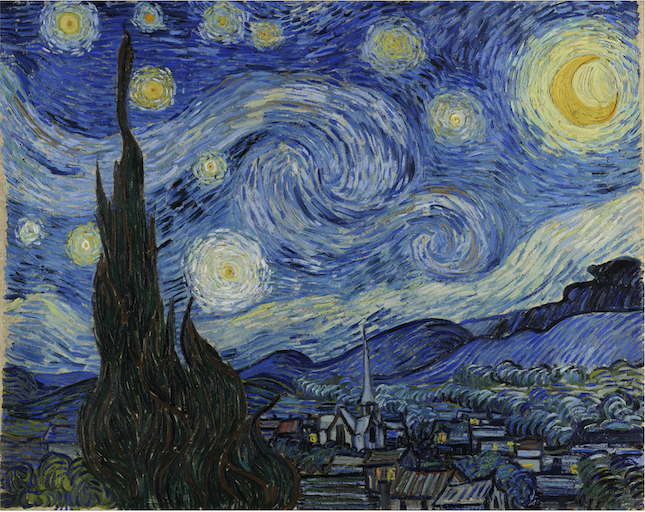

In [6]:
content_image = load("../../data/transfer_big_ben.png")
style_image = load("../../data/transfer_vangogh.png")

print(content_image.shape, style_image.shape)

show(content_image)
show(style_image)

## Style Transfer Primer

The style transfer algorithm here follows the "Image Style Transfer Using Convolutional Neural Networks" [paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) by Gatys, Ecker and Bethge in CVPR2015.

In essence, we minimize two objectives.

1. A **style** objective that minimizes differences in non-spatial feature attributes between the generated image and a target style image - here we need to discourage spatial similarity and encourage non-spatial similarity
2. A **content** objective that minimizes differences in spatial attributes between the generated image and a target content image - here we care about the correct positions of buildings, people, objects etc.

In [7]:
style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed3b',
]

In this parameterization, we stack the three images (target, content, style) and we will use these as inputs for our objective function later.

In [8]:
def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
    shape = content_image.shape[:2] # assume we use content_image.shape
    params, image = param.image(*shape, decorrelate=decorrelate, fft=fft)
    def inner():
        style_transfer_input = image()[0]
        content_input = torch.tensor(np.transpose(content_image, [2, 0, 1])).float().to(device)
        style_input = torch.tensor(np.transpose(style_image[:shape[0], :shape[1], :], [2, 0, 1])).float().to(device)
        return torch.stack([style_transfer_input, content_input, style_input])
    return params, inner

# following the original Lucid notebook,
# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2

Check that the shape is what we expect!

In [9]:
assert np.allclose(list(style_transfer_param(content_image, style_image)[1]().shape), [3, 3, 512, 512])

Since we are minimizing differences, we need to define a distance metric. Here we use L1.

In [10]:
def mean_L1(a, b):
    return torch.abs(a-b).mean()

Following the original Lucid style transfer notebook, we define a new objective with the `@wrap_objective` decorator.

The vanilla objective acts as a **content** objective.

To use it as a **style** objective, we pass a `transform_f` parameter that transforms input images into Gram matrix representations, which removes spatial information.

In [11]:
@wrap_objective()
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
    def inner(T):
        # first we collect the (constant) activations of image we're computing the difference to
        image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
        if transform_f is not None:
            image_activations = [transform_f(act) for act in image_activations]

        # we also set get the activations of the optimized image which will change during optimization
        optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
        if transform_f is not None:
            optimization_activations = [transform_f(act) for act in optimization_activations]

        # we use the supplied loss function to compute the actual losses
        losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
        return sum(losses)

    return inner

Following the original "Image Style Transfer Using Convolutional Neural Networks" [paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) by Gatys, Ecker and Bethge in CVPR2015, we use the Gram matrix to represent the images in a "spatially-invariant" manner. The Gram matrix essentially represents correlations between features and is a $N \times N$ matrix where $N$ is the number of features or channels.

In [12]:
def gram_matrix(features, normalize=True):
    C, H, W = features.shape
    features = features.view(C, -1)
    gram = torch.matmul(features, torch.transpose(features, 0, 1))
    if normalize:
        gram = gram / (H * W)
    return gram

Finally, we put everything together!

There is some tuning involved to balance between the content objective and the style objective using the `content_weight` and `style_weight` parameters.

100%|██████████| 512/512 [02:52<00:00,  2.96it/s]



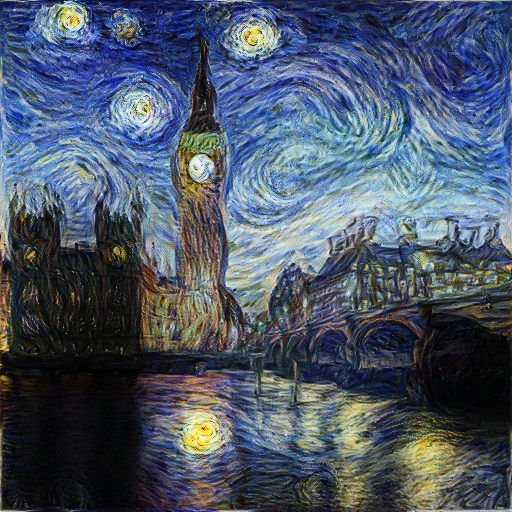
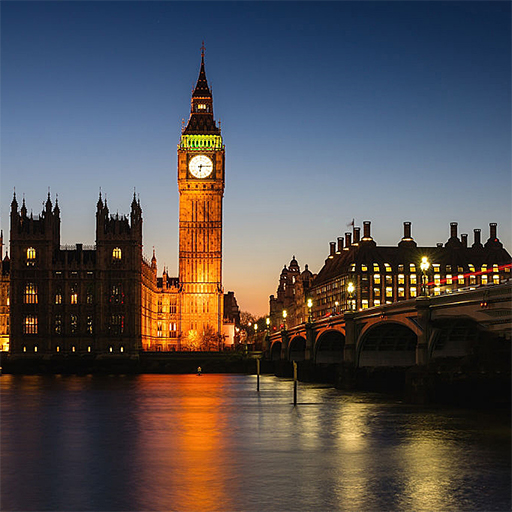
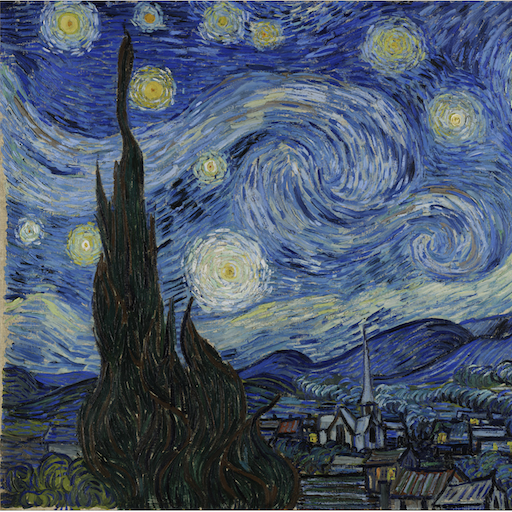

In [13]:
param_f = lambda: style_transfer_param(content_image, style_image)

content_weight = 200
style_weight = 1

content_obj = activation_difference(content_layers, difference_to=CONTENT_INDEX)
content_obj.description = "Content Loss"

style_obj = activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"

objective = content_weight * content_obj + style_weight * style_obj

vis = render.render_vis(model, objective, param_f, show_inline=True)

## Parameterization and Transformation Robustness

As discussed in the original Lucid [notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/style_transfer_2d.ipynb), parameterization and transformation play important roles here. Below we show some examples without appropriate parameterization or transformation.

Example with no spatial and channel decorrelation.

100%|██████████| 512/512 [01:24<00:00,  6.03it/s]



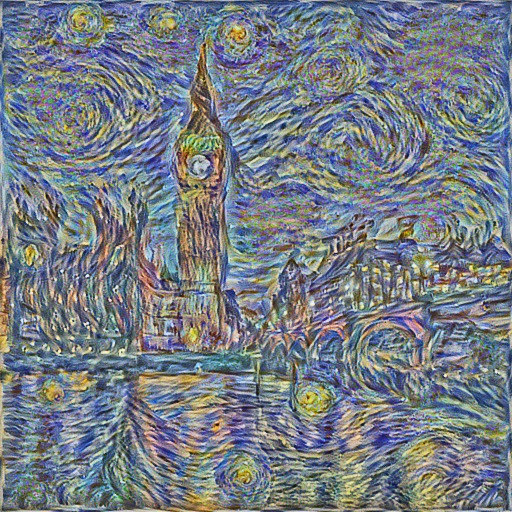

In [14]:
bad_param_f = lambda: style_transfer_param(content_image, style_image, decorrelate=False, fft=False)

bad_param_vis = render.render_vis(model, objective, bad_param_f)
show(bad_param_vis[-1][0])

Example with no transform.

100%|██████████| 512/512 [01:06<00:00,  7.75it/s]



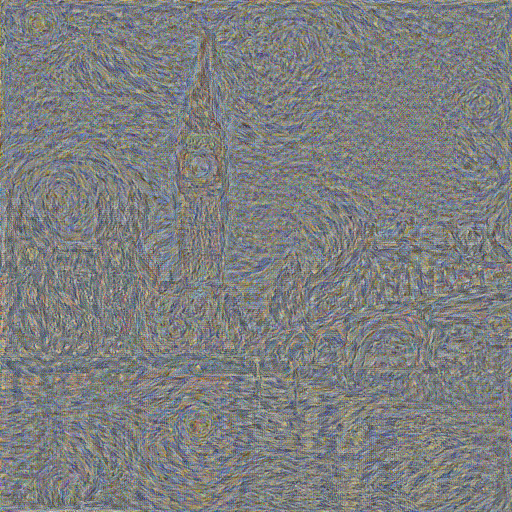

In [15]:
no_transforms_vis = render.render_vis(model, objective, bad_param_f, transforms=[])
show(no_transforms_vis[-1][0])

Just as noted in the original Lucid notebook, without appropriate parameterizations and transforms, we observe checkerboard artefacts. Check out these Distill articles for more information!

- [Feature Visualization](https://distill.pub/2017/feature-visualization/#enemy-of-feature-vis) 
- [Checkerboard Artefacts](https://distill.pub/2016/deconv-checkerboard).


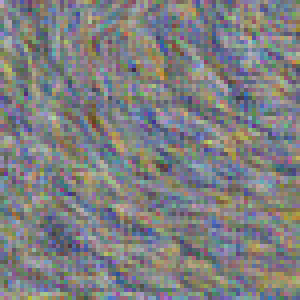

In [16]:
detail = no_transforms_vis[-1][0][-75:, 125:200, ...]
zoomed4x = np.kron(detail, np.ones((4,4,1)))
show(zoomed4x)

## Bonus experiment!

100%|██████████| 512/512 [01:20<00:00,  6.34it/s]



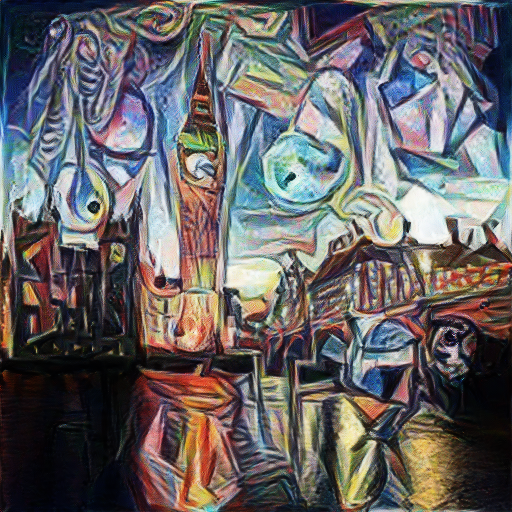
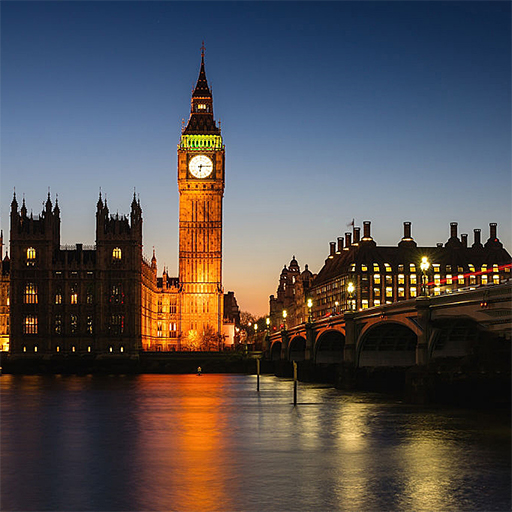
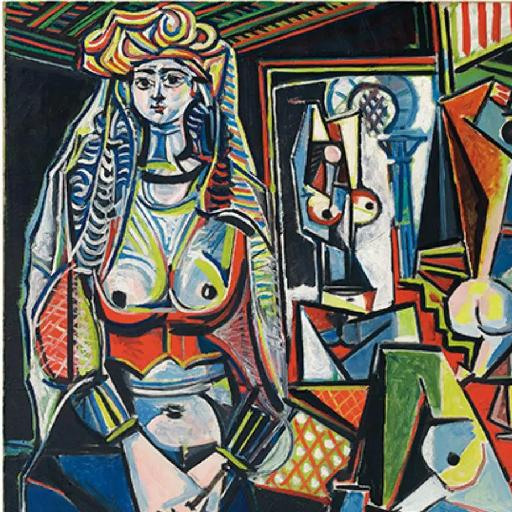

In [17]:
style_image = load("../../data/transfer_picasso.png")

param_f = lambda: style_transfer_param(content_image, style_image)

vis = render.render_vis(model, objective, param_f, show_inline=True)

Feel free to try this out with your own images!